In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_multigrid_fixed'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4787a58438> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4787a3e978>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 204      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 36 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.597       |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 37 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.614       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008558616 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0711      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 

policy iteration runtime: 41 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.638       |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009073767 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.85        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0319      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0259     |
|    std                  | 

policy iteration runtime: 41 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.655        |
| time/                   |              |
|    fps                  | 207          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0019960166 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0468       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 38 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.661      |
| time/                   |            |
|    fps                  | 209        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00624949 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.883      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0381     |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.669        |
| time/                   |              |
|    fps                  | 206          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063076317 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0548       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0267      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 25088

seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4787a3e978> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4785e1d208>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.683        |
| time/                   |              |
|    fps                  | 158          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042487443 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0587       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0264      |
|    std                  | 0.0551       |
|    value_loss           | 0.0031

policy iteration runtime: 37 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005322394 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.88        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0361      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.686      |
| time/                   |            |
|    fps                  | 166        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00399805 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.894      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0317     |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0293    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075751273 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.892        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0499       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

policy iteration runtime: 37 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039733974 |
|    clip_fraction        | 0.341        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.895        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0446       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.0287      |
|    std                  | 0.

policy iteration runtime: 37 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.688      |
| time/                   |            |
|    fps                  | 165        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.01186063 |
|    clip_fraction        | 0.371      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.896      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0419     |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0302    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066706864 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0356       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0295      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4788467e80> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4780094240>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072880806 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.883        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0613       |
|    n_updates            | 1960         |
|    policy_gradient_loss | -0.0306      |
|    std                  | 0.0551       |
|    value_loss           | 0.0039

policy iteration runtime: 52 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0028803244 |
|    clip_fraction        | 0.354        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.828        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0558       |
|    n_updates            | 2120         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

policy iteration runtime: 52 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0044819685 |
|    clip_fraction        | 0.365        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.845        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0419       |
|    n_updates            | 2280         |
|    policy_gradient_loss | -0.0311      |
|    std                  | 0.

policy iteration runtime: 51 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.697      |
| time/                   |            |
|    fps                  | 86         |
|    iterations           | 1          |
|    time_elapsed         | 29         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00422945 |
|    clip_fraction        | 0.368      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.851      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0849     |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0306    |
|    std                  | 0.055      |
|    

policy iteration runtime: 52 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0076387497 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.854        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0466       |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.0321      |
|    std                  | 0.

policy iteration runtime: 58 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008846989 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.866       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0526      |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0303     |
|    std                  |

policy iteration runtime: 51 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005953178 |
|    clip_fraction        | 0.383       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.867       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0409      |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.0316     |
|    std                  | 0.055       |
|    va

<IPython.core.display.Javascript object>


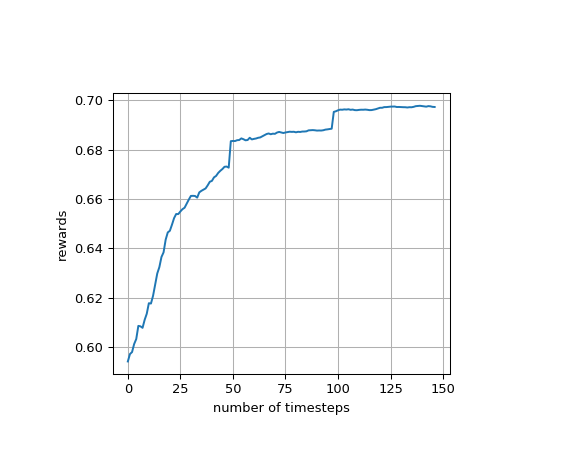

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f47540d3748> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f47540d3588>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.601       |
| time/                   |             |
|    fps                  | 199         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009355739 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0558      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.055       |
|    value_loss           | 0.00467     |
------------

policy iteration runtime: 33 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.62        |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009740907 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.799       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0473      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0251     |
|    std                  | 

policy iteration runtime: 38 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.64         |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072204424 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.839        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0607       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0261      |
|    std 

policy iteration runtime: 39 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.659        |
| time/                   |              |
|    fps                  | 212          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075268834 |
|    clip_fraction        | 0.332        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.863        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0676       |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0254      |
|    std

policy iteration runtime: 33 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.664        |
| time/                   |              |
|    fps                  | 206          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064074188 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.88         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0431       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0274      |
|    std

policy iteration runtime: 33 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.667        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063805105 |
|    clip_fraction        | 0.337        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.893        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0779       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0265      |
|    std                  | 0.

policy iteration runtime: 35 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.672       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004336402 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.897       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0759      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0275     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f47540c8be0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f47540d3128>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.685        |
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064620106 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0518       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0277      |
|    std                  | 0.0551       |
|    value_loss           | 0.0037

policy iteration runtime: 44 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004183191 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.867       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0978      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0265     |
|    std                  |

policy iteration runtime: 42 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010791781 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0586      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075651556 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.892        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0507       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0305      |
|    std                  | 0.

policy iteration runtime: 44 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0008118391 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.892        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0389       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.0289      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.69       |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00640575 |
|    clip_fraction        | 0.357      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.897      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0662     |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0295    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 44 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0093998285 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.897        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0987       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0297      |
|    std                  | 0.

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f47300492e8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f471c345c50>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 80           |
|    iterations           | 1            |
|    time_elapsed         | 31           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0062811314 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.896        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0507       |
|    n_updates            | 1960         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.055        |
|    value_loss           | 0.0035

policy iteration runtime: 52 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042289854 |
|    clip_fraction        | 0.365        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.835        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0771       |
|    n_updates            | 2120         |
|    policy_gradient_loss | -0.0297      |
|    std

policy iteration runtime: 50 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011060322 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.833       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0593      |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 52 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056864023 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.841        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0595       |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.0297      |
|    std                  | 0.

policy iteration runtime: 52 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0053860904 |
|    clip_fraction        | 0.368        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.845        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0702       |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.0312      |
|    std

policy iteration runtime: 51 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075137676 |
|    clip_fraction        | 0.368        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.842        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0542       |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.0302      |
|    std                  | 0.

policy iteration runtime: 52 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072075934 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.852        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0336       |
|    n_updates            | 2920         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

<IPython.core.display.Javascript object>


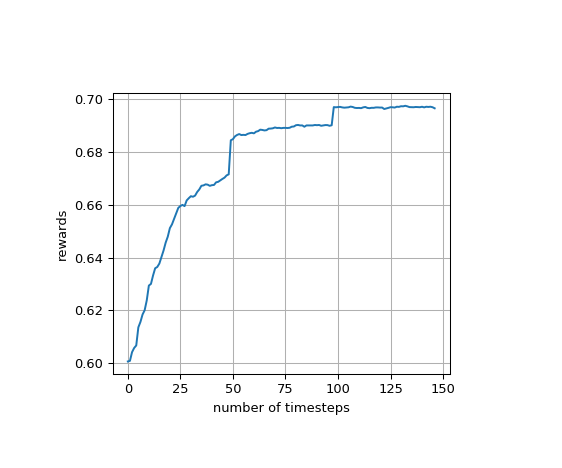

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f471c30bfd0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4787a55f28>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.599        |
| time/                   |              |
|    fps                  | 208          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0035937845 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.851        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0746       |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.0299      |
|    std                  | 0.055        |
|    value_loss           | 0.0050

policy iteration runtime: 39 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011970257 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.791       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0357      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 33 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.629        |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067400276 |
|    clip_fraction        | 0.334        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0621       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0246      |
|    std 

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.644        |
| time/                   |              |
|    fps                  | 206          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075665624 |
|    clip_fraction        | 0.343        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.876        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0725       |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0253      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.657        |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0007322341 |
|    clip_fraction        | 0.35         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.9          |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0822       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0261      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.665       |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011550871 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0637      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0269     |
|    std                  |

policy iteration runtime: 38 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.671       |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005884564 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.074       |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0266     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4787a55f28> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4787a8ff60>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006482959 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0613      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0269     |
|    std                  | 0.0551      |
|    value_loss           | 0.00311     |
------------

policy iteration runtime: 37 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007733971 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0439      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0294     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.686        |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0048668953 |
|    clip_fraction        | 0.366        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0555       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0293      |
|    std

policy iteration runtime: 36 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0031028837 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0542       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0277      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.003638485 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.901       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0664      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 43 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009528692 |
|    clip_fraction        | 0.382       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0458      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0303     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 41 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0034299463 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0736       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0276      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f4780070ef0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f471c2d4da0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 1           |
|    time_elapsed         | 31          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008223429 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.904       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0526      |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0285     |
|    std                  | 0.055       |
|    value_loss           | 0.00335     |
------------

policy iteration runtime: 52 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010331136 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.853       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0821      |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.0293     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 58 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.699       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008444381 |
|    clip_fraction        | 0.377       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.864       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0546      |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0317     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 51 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056663128 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.867        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.087        |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

policy iteration runtime: 51 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.7          |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066292137 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.879        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0497       |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.0289      |
|    std

policy iteration runtime: 52 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.7         |
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004571265 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.875       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0628      |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 60 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.7         |
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 1           |
|    time_elapsed         | 31          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004910135 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.876       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0907      |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.03       |
|    std                  | 0.055       |
|    va

<IPython.core.display.Javascript object>


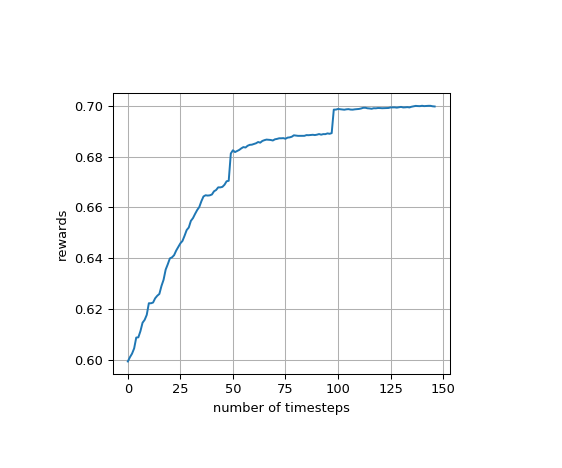

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[25000, 25000, 25000], 
                                log_dir=log_dir,
                                seed=seed)